# Overview/goals
This project showcases how *puboracle* can be used to mine PubMed and extract info on geospatial location of research activity, networks of collaborations and related matrics.

This example tracks publications with the key word "connectome" or "connectomics" in the last year and dispays key geospatial data and metrics related to these publications.

In [1]:
import math
from pathlib import Path

from puboracle.writestoredata import getdata,readwritefun
from puboracle.txtprocess import txt2geo, txtfun
from puboracle.visualization import visfun
from puboracle.metrics import txtmetrics
from puboracle.metrics import netmetrics

Submit query and fetch data in an XML format

In [ ]:
save_folder = '/Users/alexandrosgoulas/Data/work-stuff/projects/example_puboracle_connectomics/xmldata/'
query = 'connectomics OR connectome'
days = 30
email = 'arimpos@gmail.com'

getdata.fetch_write_data(
                        query = query,
                        datetype = 'pdat',
                        email = email,
                        days = days,
                        save_folder = save_folder
                        )

Read all the XML files that were downloaded

In [3]:
folder_to_xmls = Path('/Users/alexandrosgoulas/Data/work-stuff/projects/example_puboracle_connectomics/xmldata/')
all_xml_files = readwritefun.get_files_in_folder(folder_to_xmls, 
                                                 order = True
                                                )

Read the XML files and extract the desired info specified by the list keys_to_parse

In [4]:
keys_to_parse = [
                 'affiliations'
                ]

pub_data, xml_filenames = readwritefun.read_xml_to_dict(folder_to_xmls, 
                                                        all_xml_files = all_xml_files,
                                                        keys_to_parse = keys_to_parse
                                                        )


Iterating file...: xml_0.xml

Iterating file...: xml_1.xml


Extract affiliations

In [5]:
affiliations = pub_data[keys_to_parse.index('affiliations')]

Remove unwanted elements from affiliations:
i.  email address 
ii. author names or initials in parentheses (can also remove acronyms of location but this is OK)   
iii. the word "and" from the beginning of an affiliation 

In [6]:
affiliations_cleaned = txtfun.remove_email_txtinparen(affiliations,
                                                      len_threshold = 12,
                                                      delimeter = ';'
                                                      ) 

Get all the unique cleaned affiliations

In [7]:
(all_affiliations_cleaned, 
 unique_affiliations_cleaned, 
 occurences) = txtmetrics.get_unique_strs(affiliations_cleaned,
                                          exclude=['', ' ']
                                          )

Geolocation: extract latitude and longitude from the textual description of the locations in each affiliation

In [ ]:
lat,lon,txtforloc = txt2geo.get_lat_lon_from_text(
                                                  unique_affiliations_cleaned,
                                                  geophrase_delimeter = ',',
                                                  verbose = True,
                                                  reverse = False,
                                                  clean_string = 'unicode',
                                                  user_agent = 'geocoding test',
                                                  min_delay_seconds = 1
                                                  )


Unpacking textual location descriptions...: 1 / 559

Searching for latitude and longitude for location description: Institute for Neuroradiology, University Hospital, Ludwig-Maximilians-University Munich, Marchioninistrasse 15, 81377 Munich, Germany. 

Geolocation based on...: Institute for Neuroradiology

Geolocation based on...: University Hospital

Unpacking textual location descriptions...: 2 / 559

Searching for latitude and longitude for location description: Department of Psychiatry and Biobehavioral Sciences, University of California Los Angeles, Los Angeles, CA, USA.

Geolocation based on...: Department of Psychiatry and Biobehavioral Sciences

Geolocation based on...: University of California Los Angeles

Unpacking textual location descriptions...: 3 / 559

Searching for latitude and longitude for location description: Department of Radiology, Royal Hospital for Sick Children, Edinburgh EH9 1LF, UK.

Geolocation based on...: Department of Radiology

Unpacking textual locatio


Unpacking textual location descriptions...: 27 / 559

Searching for latitude and longitude for location description: Department of Physics, University of Washington, Seattle, WA 98195, USA.

Geolocation based on...: Department of Physics

Unpacking textual location descriptions...: 28 / 559

Searching for latitude and longitude for location description: Department of Nuclear Medicine, University Hospital of Munich, LMU Munich, Munich, Germany

Geolocation based on...: Department of Nuclear Medicine

Geolocation based on...: University Hospital of Munich

Geolocation based on...: LMU Munich

Unpacking textual location descriptions...: 29 / 559

Searching for latitude and longitude for location description: Department of Imaging Physics, Division of Diagnostic Imaging, The University of Texas MD Anderson Cancer Center, Houston, Texas, United States.

Geolocation based on...: Department of Imaging Physics

Geolocation based on...: Division of Diagnostic Imaging

Unpacking textual locatio

Remove lat lon nan entries and visualize the rest on a global map

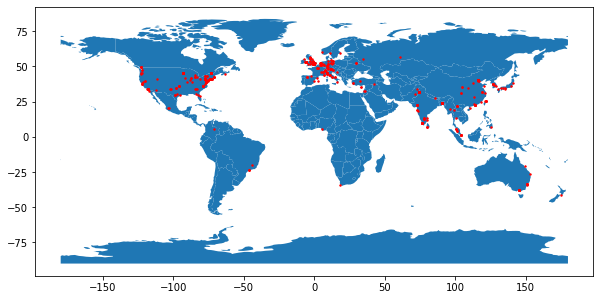

In [9]:
lat = [item for item in lat if not math.isnan(item)]
lon = [item for item in lon if not math.isnan(item)]
visfun.vis_lon_lat(longitude=lon, latitude=lat)

The above map offers an overview of the distribution of the location across the globe where research was conducted 
and resulted in a publication with the keywords "connectome" or "connectomics" in the last 30 days. 

Visualize top 10 of affiliations with the max publications, after the merge of nr of publications between affiliations
that exceed a string similarity threshold

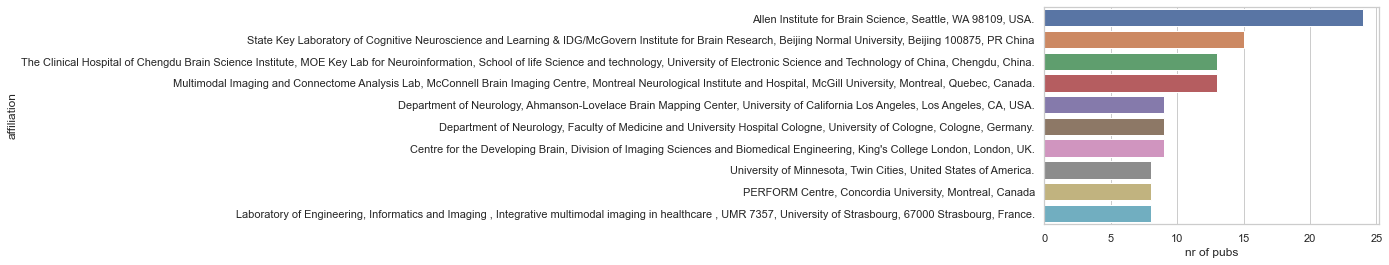

In [10]:
(affiliations_nrpubs_topmerged, 
 _) = txtmetrics.add_by_similarity(occurences, 
                                   topN = 10, 
                                   look_ahead = 100,
                                   threshold = 0.8
                                  )

visfun.visualize_counter_selection(affiliations_nrpubs_topmerged)

We can also construct a graph that captures the collaborations between department and institutes. Each unique affiliation is considered one node of the graph and edges between nodes denote the number that these affiliations apepar together in a publication.

In [12]:
co_occurying = [ac.split(';') for ac in affiliations_cleaned]
all_edges = netmetrics.construct_edges_list(unique_affiliations_cleaned, 
                                            list_coitems = co_occurying,
                                            exclude=[]
                                            ) 
net = netmetrics.create_network_from_edge_wei_list(all_edges,
                                                   nr_vertices = len(unique_affiliations_cleaned),
                                                   labels = unique_affiliations_cleaned
                                                  )

Calculating network edges...: 100%|██████████| 116/116 [00:00<00:00, 13113.56it/s]


Visualize the collaborations graph with Multi Dimensional Scaling (MDS) as an interactive figure with Plotly 

In [16]:
layt = net.layout_mds()
filename_save = '/Users/alexandrosgoulas/Data/work-stuff/python-code/projects/text_oracle/figs_puboracle_example/affil_net.html' 
visfun.plot_graph(layt,
                  net = net,
                  filename_save = filename_save,
                  title = 'Collaborations between affiliations'
                  )

In sum, with a few lines of code, puboracle can harness insights from scientific publications and offer an overview of research activity and collaborations across the globe, based on keywords that describe any domain of research within the life sciences 